In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
input_file = 'HepG2_SDOC_active_result.tsv'
infos = pd.read_csv(input_file, sep="\t", header=None)
infos

,0,1,2,3,4,5
0,chr1,2190000,3430000,10,0.437330,0.614114
1,chr1,3430000,5990000,0,1.050111,-0.520215
2,chr1,5990000,6040000,0,0.003852,-0.520215
3,chr1,6040000,6700000,3,0.203751,0.525532
4,chr1,6700000,7660000,0,0.222518,-0.520215
...,...,...,...,...,...,...
2637,chr9,136730000,136790000,0,0.006576,-0.520215
2638,chr9,136790000,136940000,34,0.024912,2.321254
2639,chr9,136940000,137120000,0,0.046040,-0.520215
2640,chr9,137120000,137280000,0,0.032555,-0.520215


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])

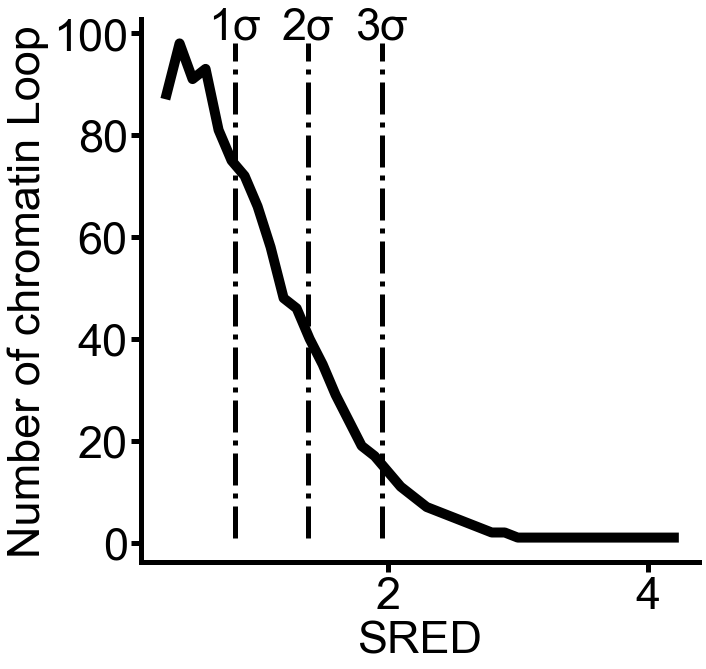

In [4]:
result = infos.loc[infos[3]>0].loc[:,5].round(1).value_counts().sort_index()
x = result.index.tolist()
y = result.values.tolist()

_sigma = infos.loc[infos[3]>0].loc[:,5].std()
_min = infos.loc[infos[3]>0].loc[:,5].min()
_thresholds = [_min+i*_sigma for i in range(1, 4)]

set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color='black', linewidth=figure_size['small'])
for i in range(3):
    axes.vlines(
        _thresholds[i], result.values.min(), result.values.max(),
        colors='black', linestyles='dashdot'
    )
    axes.text(
        _thresholds[i], result.values.max()+1, '{}σ'.format(i+1),
        fontsize=figure_size['ultra'], horizontalalignment='center'
    )

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.xlabel('SRED')
plt.ylabel('Number of chromatin Loop')
# plt.title('Distribution')
# plt.savefig('figure_file/SRED Distribution(active).pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
low = infos.loc[infos[3]>0].loc[infos[5]<_thresholds[0]].copy()
middle = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[0]].loc[infos[5]<_thresholds[1]].copy()
high = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[1]].loc[infos[5]<_thresholds[2]].copy()
ultra_high = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[2]].copy()

In [20]:
SE = pd.read_table(
    "/data1/lmh_data/MINE/source/HepG2/SE_01_0038_SE.bed",
    header=None, names=[
        'cell_id', 'se_id', 'se_chr', 'se_start', 'se_end',
        'se_rank', 'se_ele_num', 'se_snp_num', 'se_eqtl_num',
        'se_gwas_num', 'se_tfbs_num', 'se_crisps_num', 'se_conser_score',
        'se_cas_value', 'se_con_value', 'se_gene_overlap', 'se_gene_proximal',
        'se_gene_closest', 'se_gene_lasso', 'se_gene_prestige', 'se_gene_closest_active'
    ]
)
TE = pd.read_table(
    "/data1/lmh_data/MINE/source/HepG2/SE_01_0038_TE.bed",
    header=None, names=[
        'te_chr', 'te_start', 'te_end', 'cell_id', 'te_id',
        'te_rank', 'te_ele_num', 'te_CONSTITUENT_SIZE',
        'te_cas_value', 'te_con_value', 'te_gene_overlap',
        'te_gene_proximal', 'te_gene_closest', 'isSUPER'
    ]
)

def get_super_enhancer_ele_num(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)]['se_ele_num'].sum()
    return _total

def get_super_enhancer_ele_density(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)
                    ]['se_ele_num'].sum() / (end - start) * 1000
    return _total

def get_typical_enhancer_ele_num(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)]['te_ele_num'].sum()
    return _total

def get_typical_enhancer_ele_density(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)
                    ]['te_ele_num'].sum() / (end - start) * 1000
    return _total

def find_gene(df, use_SE=True, use_TE=True):
    _total = []
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]

        if use_SE:
            tmp = SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)].loc[:, [
                'se_gene_overlap', 'se_gene_proximal', 'se_gene_closest', 'se_gene_lasso',
                'se_gene_prestige', 'se_gene_closest_active']].values.flatten().astype(str)
            _tmp = []
            [_tmp.extend(i.split(',')) for i in tmp]
            tmp = np.array(_tmp).astype(str)
            _total.extend(tmp[tmp != 'nan'].tolist())

        if use_TE:
            tmp = TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)].loc[:, [
                'te_gene_overlap', 'te_gene_proximal', 'te_gene_closest']].values.flatten().astype(str)
            _tmp = []
            [_tmp.extend(i.split(',')) for i in tmp]
            tmp = np.array(_tmp).astype(str)
            _total.extend(tmp[(tmp != 'nan')&(tmp != '.')].tolist())
    return list(set(_total))

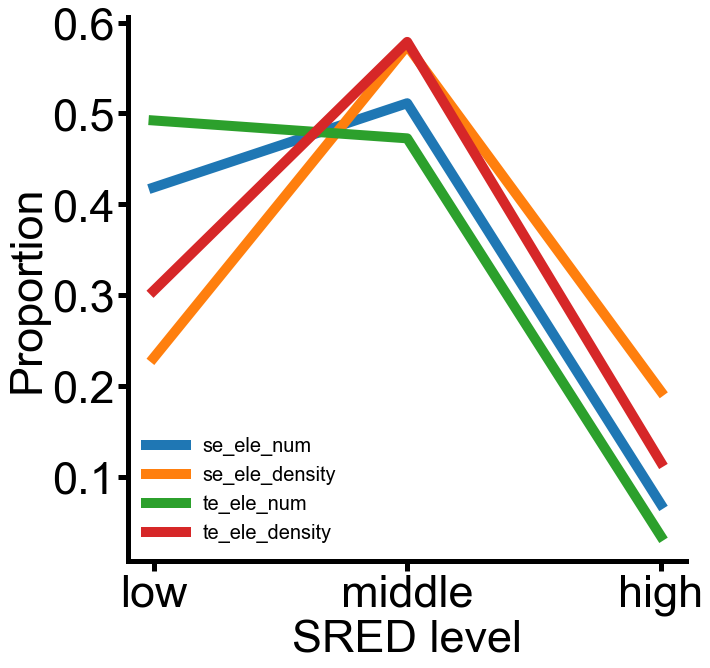

In [7]:
result = dict()
result['se_ele_num'] = [
    get_super_enhancer_ele_num(low),
    get_super_enhancer_ele_num(middle) + get_super_enhancer_ele_num(high),
    get_super_enhancer_ele_num(ultra_high)
]
result['se_ele_num'] /= sum(result['se_ele_num'])
result['se_ele_density'] = [
    get_super_enhancer_ele_density(low),
    get_super_enhancer_ele_density(middle) + get_super_enhancer_ele_density(high),
    get_super_enhancer_ele_density(ultra_high)
]
result['se_ele_density'] /= sum(result['se_ele_density'])

result['te_ele_num'] = [
    get_typical_enhancer_ele_num(low),
    get_typical_enhancer_ele_num(middle) + get_typical_enhancer_ele_num(high),
    get_typical_enhancer_ele_num(ultra_high)
]
result['te_ele_num'] /= sum(result['te_ele_num'])
result['te_ele_density'] = [
    get_typical_enhancer_ele_density(low),
    get_typical_enhancer_ele_density(middle) + get_typical_enhancer_ele_density(high),
    get_typical_enhancer_ele_density(ultra_high)
]
result['te_ele_density'] /= sum(result['te_ele_density'])

x = ['low', 'middle', 'high']
set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, result['se_ele_num'], linewidth=figure_size['small'], label='se_ele_num')
axes.plot(x, result['se_ele_density'], linewidth=figure_size['small'], label='se_ele_density')
axes.plot(x, result['te_ele_num'], linewidth=figure_size['small'], label='te_ele_num')
axes.plot(x, result['te_ele_density'], linewidth=figure_size['small'], label='te_ele_density')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('SRED level')
plt.ylabel('Proportion')
plt.show()

In [8]:
rna = pd.read_table('/data1/lmh_data/MINE/source/HepaRG_Batch1_191226.csv', sep=',')
# rna = rna.set_index('symbol')
rna

,symbol,Day0,SP_Day1,SP_Day3,SP_Day5,ST_Day1,ST_Day3,ST_Day5,2D_Day1,2D_Day3,2D_Day5
0,A1BG,0.062501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,A1BG-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,A1CF,1.924820,1.275020,4.507150,6.017080,2.791030,2.138870,3.323470,1.304830,1.139200,2.315930
3,A2M,1.327300,0.586043,3.314240,8.370110,0.783798,0.112507,0.882933,0.827809,0.104642,0.083684
4,A2M-AS1,0.148086,0.093438,0.098504,0.041710,0.080133,0.100063,0.000000,0.038554,0.078098,0.187368
...,...,...,...,...,...,...,...,...,...,...,...
26250,ZYG11A,0.919537,2.197190,1.211960,0.947031,1.448450,1.352900,1.247680,2.961140,2.918550,2.829640
26251,ZYG11B,3.267120,1.950820,2.618920,3.169710,2.314230,2.909900,3.160620,4.693910,4.871310,5.463380
26252,ZYX,97.060500,234.170000,108.590000,104.363000,165.769000,150.548000,150.158000,123.678000,95.676100,73.236900
26253,ZZEF1,1.992840,3.294880,4.996150,5.488070,4.434920,3.081780,3.663680,4.299470,4.740180,5.181750


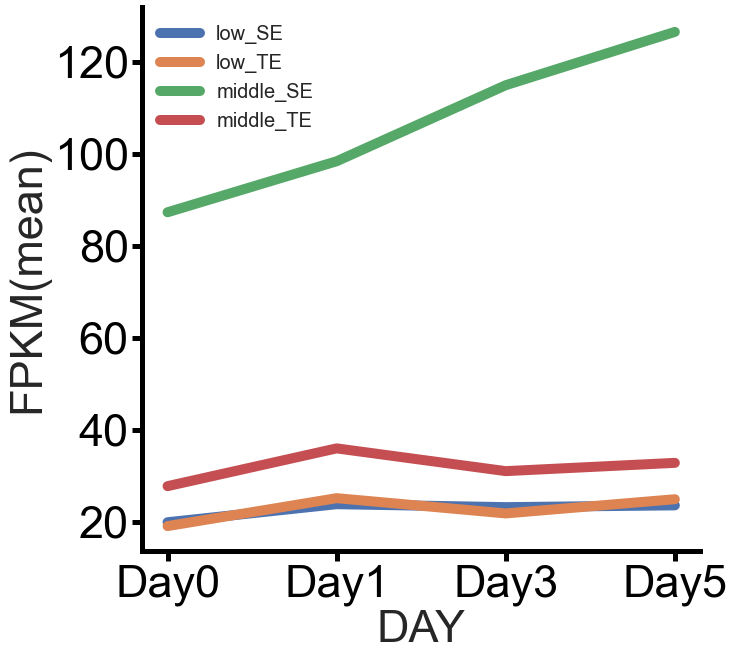

In [21]:
def get_rna(df):
    _rna = rna[rna.symbol.isin(df)].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']]
    _rna.rename(columns={'SP_Day1':'Day1','SP_Day3':'Day3','SP_Day5':'Day5'}, inplace=True)
    return _rna

_low_SE = get_rna(find_gene(low, True, False)).mean()
_low_TE = get_rna(find_gene(low, False, True)).mean()

tt = find_gene(middle, True, False).copy()
tt.extend(find_gene(high, True, False))
_middle_SE = get_rna(tt).mean()
tt = find_gene(middle, False, True).copy()
tt.extend(find_gene(high, False, True))
_middle_TE = get_rna(tt).mean()

x = ['Day0', 'Day1', 'Day3', 'Day5']
set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, _low_SE.values, linewidth=figure_size['small'], label='low_SE')
axes.plot(x, _low_TE.values, linewidth=figure_size['small'], label='low_TE')
axes.plot(x, _middle_SE.values, linewidth=figure_size['small'], label='middle_SE')
axes.plot(x, _middle_TE.values, linewidth=figure_size['small'], label='middle_TE')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('DAY')
plt.ylabel('FPKM(mean)')
plt.show()

In [ ]:
def get_SE_element_num(gene_name):
    _SE = SE[(SE.se_gene_overlap.str.contains(gene_name))|
             (SE.se_gene_proximal.str.contains(gene_name))|
             (SE.se_gene_closest.str.contains(gene_name))|
             (SE.se_gene_lasso.str.contains(gene_name))|
             (SE.se_gene_prestige.str.contains(gene_name))|
             (SE.se_gene_closest_active.str.contains(gene_name))]
#     if gene_name == 'FTL':
#         import pdb; pdb.set_trace()
    return _SE.se_ele_num.values.mean()

def get_result(df):
    elements, fpkms = [], []
    gene_names = find_gene(df, True, False)
    _rna = get_rna(gene_names)
    for gene_name in gene_names:
        if gene_name not in rna.symbol.values:
            continue
        element = get_SE_element_num(gene_name)
        if np.isnan(element):
            continue
        elements.append(element)
        fpkm = rna[rna.symbol==gene_name].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']].mean(axis=1).values[0]
        if fpkm > 10000:
            import pdb; pdb.set_trace()
        fpkms.append(fpkm)
    return elements, fpkms

low_result = get_result(low)
middle_result = get_result(pd.concat([middle, high]))

set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.scatter(low_result[0], low_result[1], linewidth=figure_size['small'], label='low_SE')
axes.scatter(middle_result[0], middle_result[1], linewidth=figure_size['small'], label='middle_SE')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('elements')
plt.ylabel('FPKM(mean)')
plt.show()

<ipython-input-83-bafe6c719e9c>:10: RuntimeWarning: Mean of empty slice.
  return _SE.se_ele_num.values.mean()
/home/lmh/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-83-bafe6c719e9c>:10: RuntimeWarning: Mean of empty slice.
  return _SE.se_ele_num.values.mean()
/home/lmh/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


> <ipython-input-83-bafe6c719e9c>(26)get_result()
     24         if fpkm > 10000:
     25             import pdb; pdb.set_trace()
---> 26         fpkms.append(fpkm)
     27     return elements, fpkms
     28 

ipdb> rna[rna.symbol==gene_name]
     symbol    Day0  SP_Day1  SP_Day3  SP_Day5  ST_Day1  ST_Day3  ST_Day5  \
6888    FTL  9145.8  7838.59  12595.4  14879.1  10126.5  8918.79  10937.3   

      2D_Day1  2D_Day3  2D_Day5  
6888  3804.05  6125.71  7971.34  


In [63]:
middle_result[1].index(max(middle_result[1]))

50

In [66]:
find_gene(pd.concat([middle, high]), True, False)[50]

'DPY19L1P1'

In [67]:
get_SE_element_num('DPY19L1P1')

2.0

In [68]:
rna[rna.symbol=='DPY19L1P1'].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']]

,Day0,SP_Day1,SP_Day3,SP_Day5
5193,0.48948,0.181695,0.287201,0.414227


In [22]:
find_gene(low, True, False)

['VAV1',
 'MRS2',
 'MRPL24',
 'SNRNP48',
 'KCNK9',
 'ANG',
 'HNT',
 'UBL7',
 'PLCD3',
 'FNIP1',
 'UBC',
 'C1orf172',
 'ST6GALNAC6',
 'PZP',
 'UBXN11',
 'C20orf185',
 'SUN5',
 'GTF2E1',
 'C3orf21',
 'PION',
 'LOC387647',
 'NEK10',
 'ABCC3',
 'GIPC1',
 'LEAP2',
 'ID2',
 'SRP14',
 'WEE1',
 'RAD51AP2',
 'C21orf84',
 'MIR3615',
 'C9orf6',
 'SEMA7A',
 'NDUFB7',
 'HNMT',
 'ZNF469',
 'RASGRF1',
 'ERN1',
 'ST1P2',
 'AGTR1',
 'SLC2A2',
 'HEPACAM',
 'RNF32',
 'TRAPPC9',
 'CRIP3',
 'CROCCP2',
 'MIR29A',
 'C3',
 'PAH',
 'C21orf125',
 'DHX37',
 'FMNL1',
 'MAT1A',
 'MIR639',
 'ACSL6',
 'FST',
 'SLC22A7',
 'GSAP',
 'ACTL7B',
 'STK39',
 'MIR4295',
 'HDGF',
 'STO',
 'SLC35D2',
 'E2F2',
 'ACTL7A',
 'NCRNA00245',
 'BCAT1',
 'CNGB1',
 'DCDC2',
 'MLX',
 'PIP5KL1',
 'PKP4',
 'SLC38A2',
 'MARVELD3',
 'LOC339788',
 'C21ORF84',
 'EPHA2',
 'LPIN2',
 'GPR116',
 'ARHGEF16',
 'LINC00261',
 'SP5',
 'ZNF683',
 'RASEF',
 'ARVELD3',
 'AT1A',
 'HEPN1',
 'TEPP',
 'VP1',
 'ABCA1',
 'HABP4',
 'LOC100129046',
 'PPP1R3G',
 '

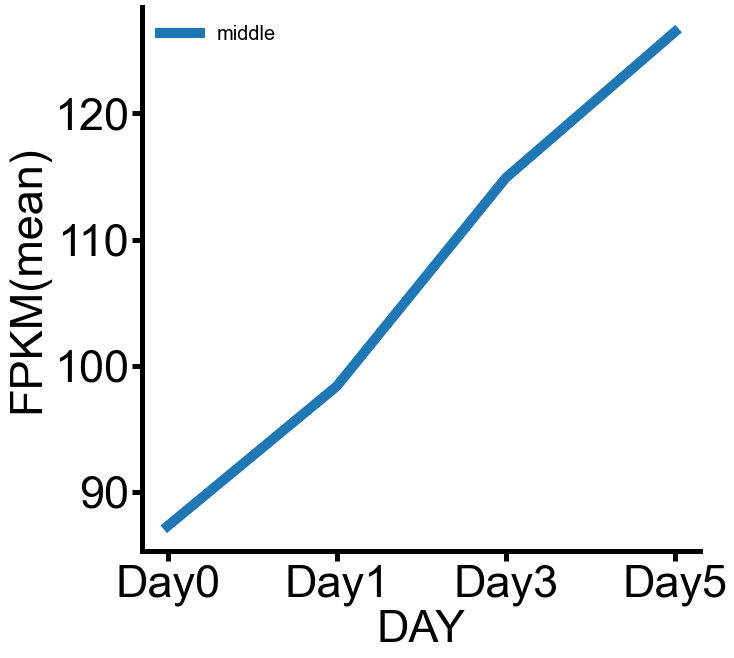

In [17]:
def get_rna(df):
    _rna = rna[rna.symbol.isin(df)].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']]
    _rna.rename(columns={'SP_Day1':'Day1','SP_Day3':'Day3','SP_Day5':'Day5'}, inplace=True)
    return _rna

_low = get_rna(find_gene(low)).mean()
tt = find_gene(middle).copy()
tt.extend(find_gene(high))
_middle = get_rna(tt).mean()

x = ['Day0', 'Day1', 'Day3', 'Day5']
set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
# axes.plot(x, _low.values, linewidth=figure_size['small'], label='low')
axes.plot(x, _middle.values, linewidth=figure_size['small'], label='middle')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('DAY')
plt.ylabel('FPKM(mean)')
plt.show()

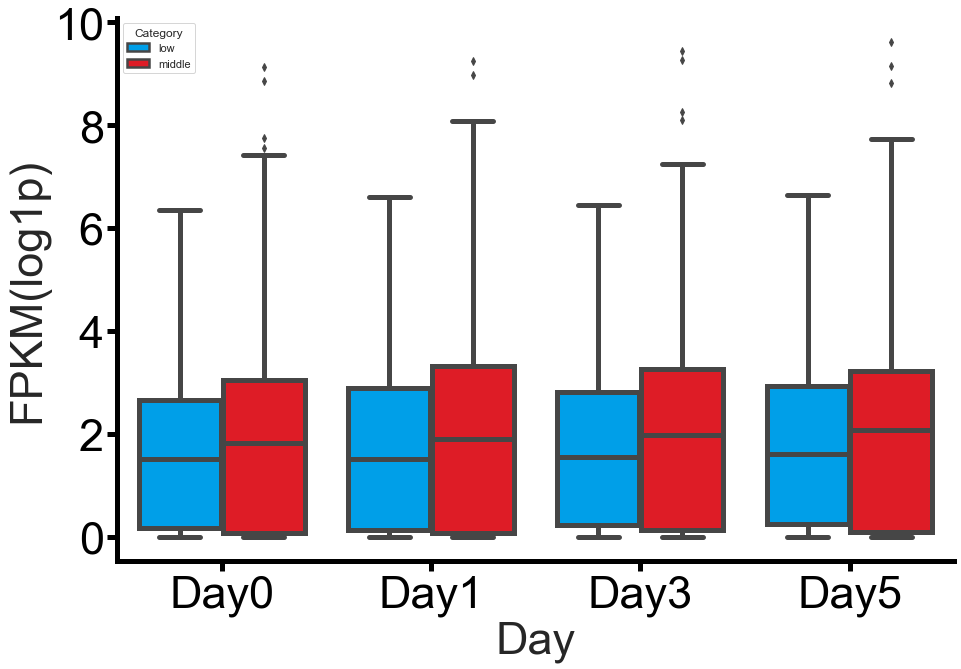

In [18]:
def get_rna(df):
    _rna = rna[rna.symbol.isin(df)].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']]
    _rna.rename(columns={'SP_Day1':'Day1','SP_Day3':'Day3','SP_Day5':'Day5'}, inplace=True)
    _rna = np.log1p(_rna)
    return _rna

def get_fpkm(rna):
    df = pd.DataFrame()
    for i, r in rna.iterrows():
        for day in ['Day0', 'Day1', 'Day3', 'Day5']:
            df = pd.concat([df, pd.DataFrame(
                data=[[day, r[day], r['Category']]], columns=['day', 'value', 'Category'])])
    return df

_low = get_rna(find_gene(low))
tt = find_gene(middle).copy()
tt.extend(find_gene(high))
_middle = get_rna(tt)

_low['Category'] = 'low'
_middle['Category'] = 'middle'
_low = get_fpkm(_low)
_middle = get_fpkm(_middle)

df = pd.concat([_low, _middle])

COLORS = [
    (0, 159/255, 232/255),
    (222/255, 28/255, 38/255),
    (0, 191/255, 82/255),
    (255/255, 122/255, 23/255)
]

my_pal = {
    "low": COLORS[0],
    "middle": COLORS[1]
}

set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="day", y="value", data=df, hue='Category',
    palette=my_pal, saturation=1, linewidth=figure_size['very_small']
)

sns.despine()
set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
# plt.xticks(rotation=10)
plt.grid(False)

plt.xlabel("Day", fontsize=figure_size['ultra'])
plt.ylabel("FPKM(log1p)", fontsize=figure_size['ultra'])

# plt.savefig('figure_file/The relationship between CTCF and SRED.pdf', format='pdf', bbox_inches='tight')
plt.show()